# Rescomp Data Analysis

In [133]:
import rescomp as rc
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import integrate, sparse
from scipy.stats import pearsonr
from scipy.sparse.linalg import eigs, ArpackNoConvergence
from scipy.sparse import coo_matrix
import math 
import networkx as nx
import itertools
import csv
import time
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
# Set seed for reproducibility
np.random.seed(1)
from math import comb
import h5py
from mpi4py import MPI
from glob import glob
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator

In [134]:
results_path = '/nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results_old/'
p_thins = np.concatenate((np.arange(0, 0.8, 0.1), np.arange(0.8, 0.99, 0.02)))
rhos = [0.1,0.9,1.0,1.1,2.0,5.0,10.0,25.0,50.0]

In [135]:
def get_file_data(hdf5_file='results/erdos_results_0.h5'):
    """
    
    """

    with h5py.File(hdf5_file, 'r') as file:
        vpt_thinned_list = []
        div_pos_thinned_list = []
        div_der_thinned_list = []
        consistency_thinned_list = []

        for group_name in file.keys():
            group = file[group_name]
            if 'mean_vpt_thinned' not in list(group.attrs):
                continue
            vpt_thinned_list.append(group.attrs['mean_vpt_thinned'])
            div_pos_thinned_list.append(group.attrs['div_pos_thinned'])
            div_der_thinned_list.append(group.attrs['div_der_thinned'])
            consistency_thinned_list.append(group.attrs['mean_consistency_thinned'])
            # print('{}, c: {}, vpt_connected: {}, p_thin: {}, vpt_thinned: {}'.format(group_name, c, vpt_connected, p_thin, vpt_thinned))
        # print('vpt_connected_average: {}, vpt_thinned_average: {}'.format(np.mean(vpt_connected_list), np.mean(vpt_thinned_list)))
        
        mean_vpt = np.mean(vpt_thinned_list)
        mean_div_pos = np.mean(div_pos_thinned_list)
        mean_div_der = np.mean(div_der_thinned_list)
        mean_consistency = np.mean(consistency_thinned_list)
        print(f"Number of draws successfully made for {hdf5_file}: {len(vpt_thinned_list)}")
        print(f"Mean diversity: {mean_div_pos, mean_div_der}")
        
        return mean_vpt, mean_div_pos, mean_div_der, mean_consistency

In [136]:
def get_system_data(p_thins, rhos, results_path=results_path):
    """
    
    """
    mean_vpts = np.zeros((len(rhos), len(p_thins)))
    mean_pos_divs = np.zeros((len(rhos), len(p_thins)))
    mean_der_divs = np.zeros((len(rhos), len(p_thins)))
    mean_consistencies = np.zeros((len(rhos), len(p_thins)))

    for i, rho in enumerate(rhos):
        for j, p_thin in enumerate(p_thins):
            hdf5_file = results_path + f"erdos_results_rho={round(rho,2)}_p_thin={round(p_thin,2)}.h5"
            mean_vpts[i,j], mean_pos_divs[i,j], mean_der_divs[i,j], mean_consistencies[i,j] = get_file_data(hdf5_file=hdf5_file)
            print("VPT", mean_vpts[i,j])

    print(f"Overall: {np.max(mean_consistencies), np.min(mean_consistencies)}")
    return mean_vpts, mean_pos_divs, mean_der_divs, mean_consistencies

In [137]:
def create_system_plot(values, ax, title, threshold):
    """
    
    """

    cmap = 'viridis'
    # norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(values[np.isfinite(values)]))
    norm = matplotlib.colors.Normalize(vmin=0, vmax=min([np.max(values[np.isfinite(values)]), threshold]))
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

    # Create evenly spaced grid for plotting
    x_even = np.linspace(0, 1, len(p_thins))  # evenly spaced x-coordinates
    y_even = np.linspace(0, 1, len(rhos))  # evenly spaced y-coordinates

    # X, Y = np.meshgrid(p_thins, rhos)
    ax.pcolormesh(x_even, y_even, values, shading='nearest', norm=norm, cmap=cmap)
    # ax.pcolormesh(X, Y, values, shading='nearest', cmap=cmap)
    
    ax.set_title(title)
    ax.set_xlabel('p_thin')
    ax.set_ylabel('rho')
    ax.set_xticks(x_even)
    ax.set_xticklabels(p_thins)  # map to original uneven x-values
    ax.set_yticks(y_even)
    ax.set_yticklabels(rhos)  # map to original uneven y-values
    ax.set_aspect('equal', adjustable='box')  # Ensure square cells

    
    # Format the ticks to show 1 decimal place and set them as labels
    ticks = ax.get_xticks()
    ax.set_xticklabels([f'{tick:.1f}' for tick in ticks])

    # Reduce visible x-axis labels
    labels = ax.get_xticklabels()
    for i, label in enumerate(labels):
        if i % 3 != 0:  # Show every 3rd label
            label.set_visible(False)
    
    plt.colorbar(mappable=sm, ax=ax)

In [138]:
def create_plots(mean_values=None, thresholds=[10,10,10,10], cutoff=False):
    fig, axs = plt.subplots(1,4, figsize=(14,3.2))
    
    if mean_values is None:
        mean_values = get_system_data(p_thins, rhos, results_path=results_path)

    titles = ['VPT', 'Div_Pos', 'Div_Der', 'Consistency']

    for i in range(len(mean_values)):
        if cutoff:
            mean_values[i][mean_values[i] > thresholds[i]] = 0
        create_system_plot(mean_values[i], axs[i], titles[i], thresholds[i])

    plt.tight_layout()
    plt.show()

### Analysis on c=4

In [139]:
# results_1_path = results_path + 'erdos_results_rho=2.0_p_thin=0.1.h5'
# get_file_data(hdf5_file=results_1_path)

In [140]:
mean_values = get_system_data(p_thins, rhos, results_path=results_path)

Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results_old/erdos_results_rho=0.1_p_thin=0.0.h5: 9100
Mean diversity: (21.803109476910556, 21.533379786483177)
VPT 0.17315934065934138
Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results_old/erdos_results_rho=0.1_p_thin=0.1.h5: 10000
Mean diversity: (37.709821967590386, 37.4308770928948)
VPT 0.16266700000000087
Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results_old/erdos_results_rho=0.1_p_thin=0.2.h5: 10000
Mean diversity: (10.220821157255859, 9.942332544537583)
VPT 0.8694130000000009
Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results_old/erdos_results_rho=0.1_p_thin=0.3.h5: 10000
Mean diversity: (27.653265333352294, 27.429098891066005)
VPT 0.8047790000000007
Number of draws successfully made for /nobackup/au

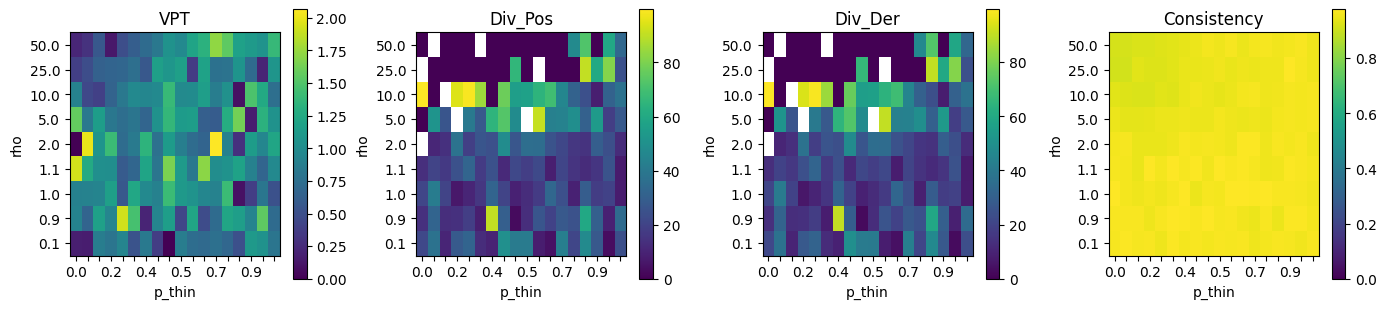

In [147]:
create_plots(mean_values, thresholds=[3, 100, 100, 10], cutoff=True)

### Variance of the Diversity Metrics Analysis

In [142]:
mean_vpts, mean_pos_divs, mean_der_divs, mean_consistencies = get_system_data(p_thins, rhos, results_path)

Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results_old/erdos_results_rho=0.1_p_thin=0.0.h5: 9100
Mean diversity: (21.803109476910556, 21.533379786483177)
VPT 0.17315934065934138


KeyboardInterrupt: 

In [128]:
print(np.max(mean_pos_divs), np.max(mean_der_divs))
print(np.min(mean_pos_divs), np.min(mean_der_divs))
print(np.sum(mean_pos_divs > 10000), np.sum(mean_der_divs > 10000))
pos_flat = mean_pos_divs.flatten()
der_flat = mean_der_divs.flatten()
print(len(der_flat))
cov = np.cov(pos_flat, der_flat)
print(cov)

50229.35292360378 50542.50036849369
0.09566371096046854 0.0006079440228817406
7 7
162
[[44171265.22671429 44423927.38734775]
 [44423927.38734775 44678328.01803713]]


In [129]:
print(np.divide(mean_pos_divs, mean_der_divs))

[[ 39.82136755  19.71041106  24.47112803  27.80069422  30.1321409
    0.99482438  31.84687993  28.53586572  21.63302118  25.2439756
   20.34639068  17.86638966  49.38530437  29.45596598  33.34800235
   55.25601501  29.69431902  20.86596312]
 [ 26.28352649  46.25050511  23.50499145   3.65329775  24.77439935
   29.45602127  26.17485028  31.19013051  10.16956023  17.16826037
   19.14556351   9.10425634  14.55517551  19.9227125   48.5395754
   18.60666271  15.53411568  14.78264642]
 [ 26.2478186   20.31235105  34.19286069  14.06304861  22.22860868
   17.22425591  14.7785248   30.66113797  21.60748293  13.28448808
   29.18033964  17.13134589  14.4675473  106.52133236  28.739644
   33.14631773  31.69418511  26.1214847 ]
 [ 37.99358294  52.7967924   44.75606692  30.92634479  58.77475644
   39.09710825  21.52140998  22.92500838  48.15576668  33.1447366
   17.03788461  10.85015311  30.03689531  17.40686227  24.62594652
   58.6389661   47.21037555  19.91452176]
 [ 22.22164993  48.48539377  58.12

In [130]:
threshold = 10

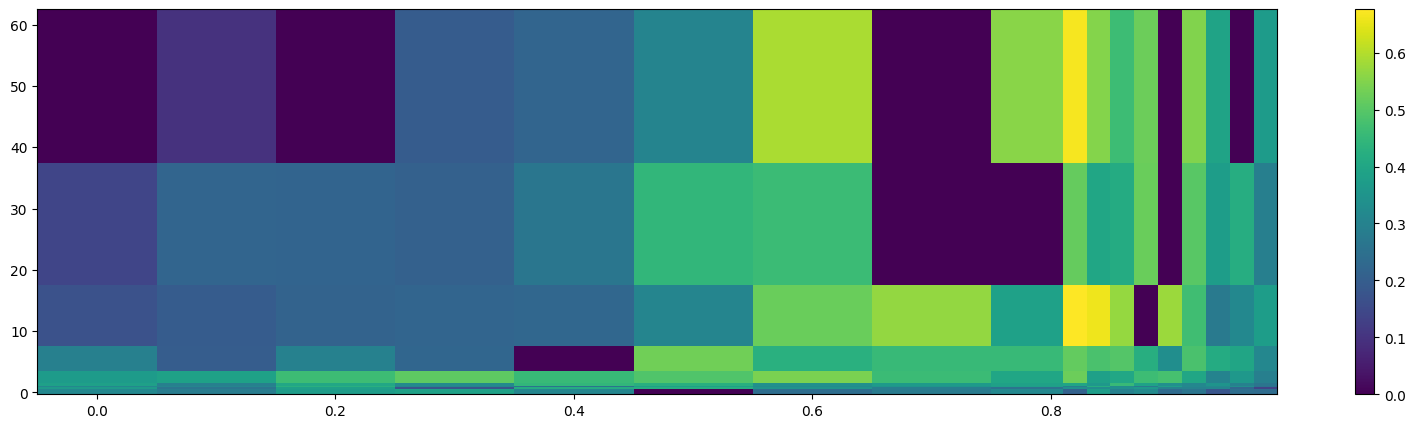

In [131]:
X, Y = np.meshgrid(p_thins, rhos)
# ax.pcolormesh(X, Y, values, shading='nearest', norm=norm, cmap=cmap)
plot_pos_divs = np.copy(mean_pos_divs)
plot_pos_divs[plot_pos_divs > threshold] = 0
plt.pcolormesh(X, Y, plot_pos_divs)
plt.colorbar()
plt.show()
plt.close()

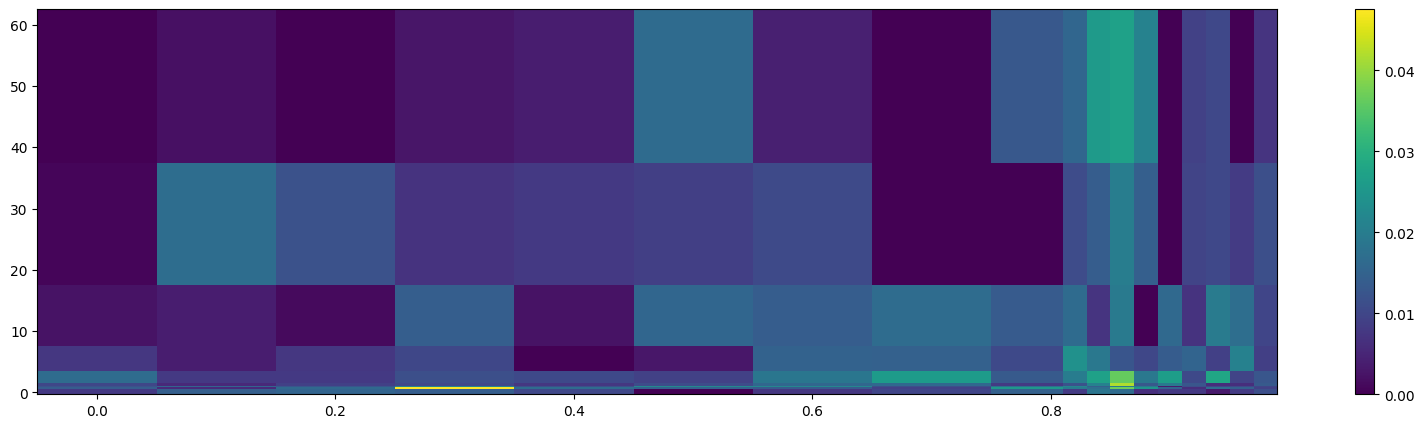

In [132]:
X, Y = np.meshgrid(p_thins, rhos)
# ax.pcolormesh(X, Y, values, shading='nearest', norm=norm, cmap=cmap)
plot_der_divs = np.copy(mean_der_divs)
plot_der_divs[plot_der_divs > threshold] = 0
plt.pcolormesh(X, Y, plot_der_divs)
plt.colorbar()
plt.show()